Initialise  
Mid price - classification rather than, 
Label - neural network (Random Forest)
mid-price

In [1]:
import numpy as np
import pandas as pd
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import glob
import re
from datetime import datetime

Import data

In [17]:
# Path pattern to match all CSV files
path_pattern = r'C:\Users\Tim\Documents\Bristol Uni\dsmp-2024-group18\ARIMA Model Development\Month Prediction\Month Data\January\*.csv'
all_files = glob.glob(path_pattern)
# List to hold all dataframes
li = []

for filename in all_files:
    # Extract date from filename using regex
    date_match = re.search(r'(\d{4}-\d{2}-\d{2})', filename)
    if date_match:
        file_date = datetime.strptime(date_match.group(), '%Y-%m-%d').date()
    
    df = pd.read_csv(filename, index_col=None, header=0)
    
    # Combine the extracted date with each 'Time' entry, assuming 'Time' is just time
    df['Time'] = pd.to_datetime(df['Time'].astype(str)).apply(lambda x: datetime.combine(file_date, x.time()))
    
    li.append(df)

# Concatenate all data into a single DataFrame
data = pd.concat(li, axis=0, ignore_index=True)

# Ensure 'Time' includes full datetime information and set it as the index
data.set_index('Time', inplace=True)

# Select only the numeric columns for resampling
numeric_data = data.select_dtypes(include=[np.number])

# Resample the numeric data to every minute, calculating the mean
data = numeric_data.resample('1T').mean()

data = data.dropna(subset=['Mid-Price'])

print(data.head())


C:\Users\Tim\AppData\Local\Temp\ipykernel_9388\2991310832.py:17: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Time'] = pd.to_datetime(df['Time'].astype(str)).apply(lambda x: datetime.combine(file_date, x.time()))
C:\Users\Tim\AppData\Local\Temp\ipykernel_9388\2991310832.py:17: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Time'] = pd.to_datetime(df['Time'].astype(str)).apply(lambda x: datetime.combine(file_date, x.time()))
C:\Users\Tim\AppData\Local\Temp\ipykernel_9388\2991310832.py:17: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Time'] = pd.to_datetime(df['T

                      Mid-Price  Total_volume  Bid_ask_spread  Order_imbalance
Time                                                                          
2025-01-02 07:30:00  263.588667    178.266667       20.544833         0.057500
2025-01-02 07:31:00  260.393500    157.416667        4.887333         0.122167
2025-01-02 07:32:00  265.426667    160.966667        4.646667         0.162667
2025-01-02 07:33:00  265.109333    150.300000        4.184167         0.041167
2025-01-02 07:34:00  265.925167    202.983333        5.501167         0.143500


C:\Users\Tim\AppData\Local\Temp\ipykernel_9388\2991310832.py:31: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  data = numeric_data.resample('1T').mean()


Get a df with just time and mid-price

In [3]:
order_imbalance_df = pd.DataFrame()
order_imbalance_df['Order_imbalance'] = data['Order_imbalance']
order_imbalance_df.set_index(data.index, inplace=True)
order_imbalance_df.reset_index(drop=True, inplace=True)

print(type(order_imbalance_df))
print(order_imbalance_df.to_string(index=True, header=True))


<class 'pandas.core.frame.DataFrame'>
       Order_imbalance
0         5.750000e-02
1         1.221667e-01
2         1.626667e-01
3         4.116667e-02
4         1.435000e-01
5         1.853333e-01
6         1.350000e-02
7         1.525000e-01
8         3.950000e-02
9         1.253333e-01
10        1.851667e-01
11        7.216667e-02
12        2.403333e-01
13        8.683333e-02
14        1.383333e-01
15        1.983333e-01
16       -4.350000e-02
17        2.485000e-01
18        3.416667e-01
19        2.775000e-01
20        1.101667e-01
21        2.233333e-01
22        2.573333e-01
23        8.950000e-02
24        1.600000e-02
25        1.550000e-01
26        1.838333e-01
27        1.471667e-01
28        2.700000e-02
29        1.828333e-01
30        1.075000e-01
31        3.088333e-01
32        1.630000e-01
33        7.633333e-02
34        3.166667e-01
35        1.483333e-01
36        4.533333e-02
37        2.516667e-01
38        4.836667e-01
39        1.005000e-01
40        3.131667e

Split the data 80:20 by time

       Order_imbalance
11215         0.375667
11216         0.211667
11217         0.261000
11218         0.180000
11219         0.017500


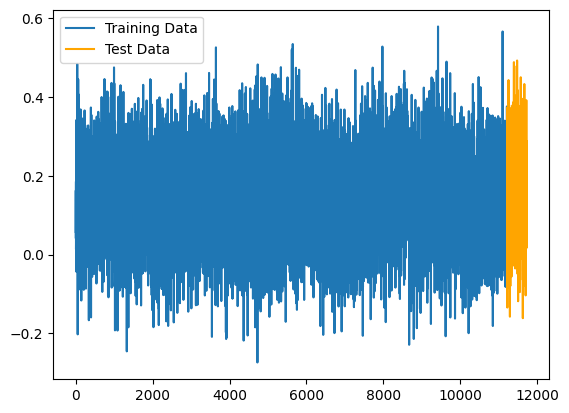

In [4]:
# Get just the mid price
day_length = 510 # 510 points per day

split_index = int(len(data) - day_length)


# Split the DataFrame into train and test sets based on the split index
train = (order_imbalance_df[0:split_index])
test = (order_imbalance_df[split_index:])

print(train.tail())

plt.plot(train, label = 'Training Data')
plt.plot(test, color = 'orange', label = 'Test Data')
plt.legend()
plt.show()


Do ADF Test to check if data is stationary 

In [5]:
#Ho: It is non stationary
#H1: It is stationary

def adfuller_test(order_imbalance):
    result=adfuller(order_imbalance)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")
    

In [6]:
adfuller_test(train['Order_imbalance'])

ADF Test Statistic : -14.976214805517053
p-value : 1.1802150103672704e-27
#Lags Used : 28
Number of Observations Used : 11191
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


Plot ACF

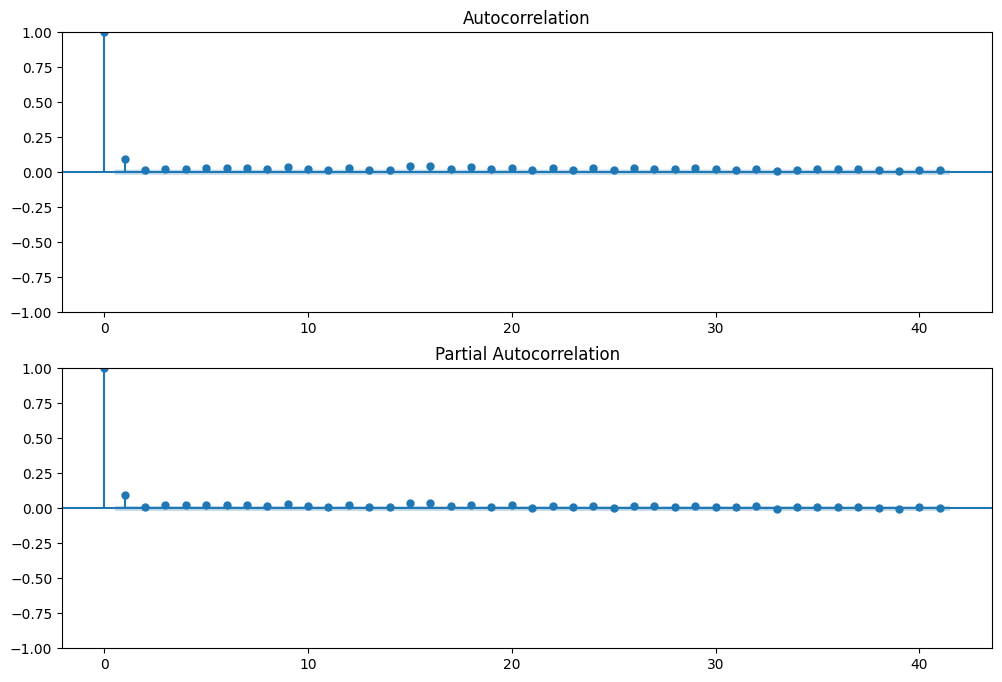

In [7]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, ax = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(train, ax=ax[0])  # ACF plot for 'Mid-Price'
plot_pacf(train, ax=ax[1])  # PACF plot for 'Mid-Price'

plt.show()

Use pdarima package to check d calc

In [8]:
from pmdarima.arima.utils import ndiffs 
ndiffs(train, test = "adf")

0

Plot interpretation

ACF Plot Interpretation:

The ACF plot tails off gradually, which indicates that the data may be either an AR process or a mixed ARMA process. In an ACF plot for a pure MA process, we would expect a sharp cut-off after the significant lags. Therefore p = 1.

PACF Plot Interpretation:

The PACF plot shows a significant spike at lag 1, and then it almost immediately cuts off (becomes insignificant). Given the lack of significant spikes in the ACF plot beyond the immediate lag, I will start with q=0 and test q=1 as well.

Differencing Term (d):

As per the ADF test, the data is stationary so d = 0




Do ARIMA Test

In [9]:
print(train)

       Order_imbalance
0             0.057500
1             0.122167
2             0.162667
3             0.041167
4             0.143500
...                ...
11215         0.375667
11216         0.211667
11217         0.261000
11218         0.180000
11219         0.017500

[11220 rows x 1 columns]


In [10]:
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA

# Use auto_arima to find the best ARIMA parameters
auto_model = auto_arima(train, seasonal=False, trace=True)
# Print the summary of the best model
print(auto_model.summary())
# Extract the best order
best_order = auto_model.order
print("Best ARIMA order:", best_order)

# Now you can use the best order to fit your ARIMA model
model = ARIMA(train, order=best_order)
model_fit = model.fit()


Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-17828.931, Time=4.13 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-6974.668, Time=0.36 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-13150.539, Time=0.17 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-10399.666, Time=0.48 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-17886.527, Time=3.77 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=-11785.565, Time=0.93 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-17832.926, Time=2.48 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=-17885.031, Time=4.72 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=-12660.753, Time=1.07 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-17885.429, Time=3.72 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=inf, Time=5.35 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-17770.046, Time=2.98 sec

Best model:  ARIMA(1,0,2)(0,0,0)[0]          
Total fit time: 30.177 seconds
                               SARIMAX Results                         

C:\Users\Tim\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Tim\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


In [12]:
horizon = 1  # Predicting one step ahead

predictions = []
actuals = []

# Start the rolling forecasting
for end in range(split_index, len(order_imbalance_df) - horizon + 1):
    
    # Extract current training data
    train = order_imbalance_df['Order_imbalance'].iloc[:end]
    
    # Fit the ARIMA model with the chosen order
    model = ARIMA(train, order=best_order)  # Ensure you've chosen the best order
    model_fit = model.fit()
    
    # Forecast the next point
    forecast = model_fit.forecast(steps=horizon)
    predictions.append(forecast.iloc[0])  # Appending the forecasted value
    
    # Appending the actual value for comparison
    actuals.append(order_imbalance_df['Order_imbalance'].iloc[end + horizon - 1])


C:\Users\Tim\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Tim\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Tim\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregre

In [13]:
from sklearn.metrics import mean_squared_error
error = mean_squared_error(actuals, predictions)
print('Test Mean Squared Error:', error)

print(predictions)
print(actuals)

Test Mean Squared Error: 0.012348583349569323
[0.12638924064397297, 0.1295235760062931, 0.12283394808192666, 0.1182275887724708, 0.13725001424149977, 0.11872684565890398, 0.10928469280091518, 0.13149545272893423, 0.13829899053385403, 0.13537197855908886, 0.13123736692522966, 0.13848348894856416, 0.12811898886619177, 0.15101933826535818, 0.13563631216291233, 0.13684749110111794, 0.15287733498220038, 0.13806078823237786, 0.14471593955251688, 0.14179178860751948, 0.14639173747480388, 0.13843617125849472, 0.15408973849934976, 0.13709294665818522, 0.13377655071587574, 0.13712559087360365, 0.14111210700095478, 0.13872260804388833, 0.14174917634708462, 0.1476978074619486, 0.14231294493268087, 0.14156872739685986, 0.13968534680288705, 0.1530435868688221, 0.15013697591542446, 0.14151718522698825, 0.1527668991849701, 0.13735420190360062, 0.16839864310136424, 0.14819363215596693, 0.1538424936982481, 0.14568341291003448, 0.1452061662246135, 0.15565072793334697, 0.13919948648130573, 0.1507624835017

Plot

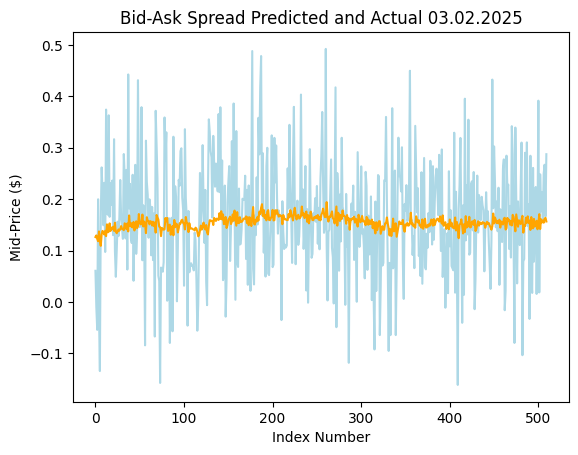

In [14]:
plt.plot(actuals, color = 'lightblue', label = 'Actual')
plt.plot(predictions, color = 'orange', label = 'Predicted')
plt.title('Bid-Ask Spread Predicted and Actual 03.02.2025')
plt.xlabel('Index Number')
plt.ylabel('Mid-Price ($)')
plt.show()

In [15]:
from sklearn.metrics import mean_squared_error
error = mean_squared_error(actuals, predictions)
print('Test Mean Squared Error:', error)

print(predictions)
print(actuals)

Test Mean Squared Error: 0.012348583349569323
[0.12638924064397297, 0.1295235760062931, 0.12283394808192666, 0.1182275887724708, 0.13725001424149977, 0.11872684565890398, 0.10928469280091518, 0.13149545272893423, 0.13829899053385403, 0.13537197855908886, 0.13123736692522966, 0.13848348894856416, 0.12811898886619177, 0.15101933826535818, 0.13563631216291233, 0.13684749110111794, 0.15287733498220038, 0.13806078823237786, 0.14471593955251688, 0.14179178860751948, 0.14639173747480388, 0.13843617125849472, 0.15408973849934976, 0.13709294665818522, 0.13377655071587574, 0.13712559087360365, 0.14111210700095478, 0.13872260804388833, 0.14174917634708462, 0.1476978074619486, 0.14231294493268087, 0.14156872739685986, 0.13968534680288705, 0.1530435868688221, 0.15013697591542446, 0.14151718522698825, 0.1527668991849701, 0.13735420190360062, 0.16839864310136424, 0.14819363215596693, 0.1538424936982481, 0.14568341291003448, 0.1452061662246135, 0.15565072793334697, 0.13919948648130573, 0.1507624835017

In [26]:
# Generate a datetime index with any base date
time_index = pd.date_range(start="2025-02-03 07:30:00", periods=510, freq='T')

# Extract just the time component, though note these are still datetime objects, just formatted to show only time
time_only_series = time_index.time

C:\Users\Tim\AppData\Local\Temp\ipykernel_9388\1862818226.py:2: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  time_index = pd.date_range(start="2025-02-03 07:30:00", periods=510, freq='T')


Export to CSV

In [27]:
order_imbalance_pred = pd.DataFrame()
order_imbalance_pred['Actual'] = actuals
order_imbalance_pred['Predicted'] = predictions
order_imbalance_pred.set_index(time_only_series, inplace=True)

order_imbalance_pred.to_csv('Predicted Order Imbalance (Month).csv')